In [103]:
import pandas as pd
import seaborn as sns
from pathlib import Path

In [104]:
ASSETS_PATH = (Path.cwd() / ".." / "assets").absolute().resolve()


In [105]:
interactions = pd.read_csv(ASSETS_PATH / "interactions.csv", index_col=0)
interactions.drop(columns=["timestamp", "userId"], inplace=True)
interactions.head(1)

,movieId
0,1


In [106]:
general_view_count = pd.DataFrame(
    columns=["views", "movie_id"],
)

In [107]:
grouped_interactions = interactions.groupby("movieId")
general_view_count["views"] = grouped_interactions["movieId"].transform("count").astype("Int64")
general_view_count["movie_id"] = grouped_interactions["movieId"].transform("first").astype("Int64")
general_view_count.drop_duplicates(subset="movie_id", inplace=True)
general_view_count.sort_values(by="views", ascending=False, inplace=True)
general_view_count.set_index("movie_id", inplace=True)
general_view_count = general_view_count.where(general_view_count["views"] > 1)
general_view_count.dropna(inplace=True)


In [108]:
general_view_count.describe()

,views
count,3563.0
mean,17.472074
std,27.256419
min,2.0
25%,3.0
50%,7.0
75%,19.0
max,329.0


In [109]:
general_view_count.to_csv(ASSETS_PATH / "general_view_count.csv")

c:\Users\Gabriel Faundez\AppData\Local\pypoetry\Cache\virtualenvs\movie-recommender-qU7K9L6K-py3.10\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Gabriel Faundez\AppData\Local\pypoetry\Cache\virtualenvs\movie-recommender-qU7K9L6K-py3.10\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'Histogram of views per movie'}, xlabel='Views', ylabel='Number of movies'>

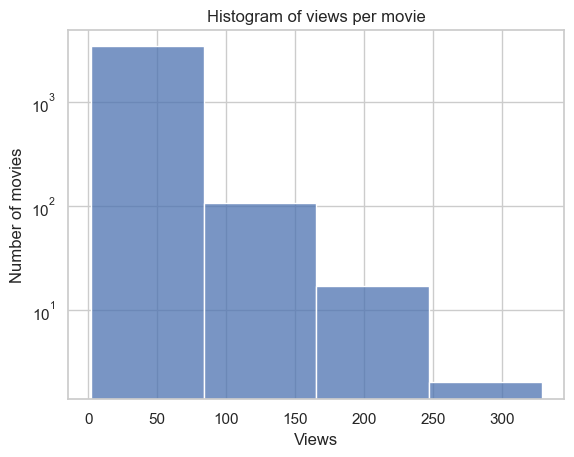

In [110]:
# plot histogram of views
sns.set_theme(style="whitegrid")
ax = sns.histplot(data=general_view_count, x="views", bins=4)
ax.set(xlabel="Views", ylabel="Number of movies",
       yscale="log")
ax.set_title("Histogram of views per movie")
ax

In [111]:
interactions_time_series = pd.read_csv(ASSETS_PATH / "interactions.csv", index_col=0).sort_values(by=["timestamp"], ascending=False)

In [112]:
tetsing_time_series = interactions_time_series[interactions_time_series["userId"] == 1]
tetsing_time_series.drop(columns=["userId"], inplace=True)
tetsing_time_series.set_index("timestamp", inplace=True)
tetsing_time_series

C:\Users\Gabriel Faundez\AppData\Local\Temp\ipykernel_230776\1263705794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tetsing_time_series.drop(columns=["userId"], inplace=True)


,movieId
timestamp,
964984176,2012
964984153,553
964984112,1445
964984100,157
964984054,3448
...,...
964980868,101
964980683,3617
964980668,3578


In [113]:
# create time series dataset where for each last 10 movies watched, we have the next movie watched
window = 5
time_series = pd.DataFrame(
    columns=[*[ f"movie_id_{movie}" for movie in range(window)], "next_movie_id"],
)
for movie in range(window):
    time_series[f"movie_id_{movie}"] = tetsing_time_series["movieId"].shift(movie)
time_series["next_movie_id"] = tetsing_time_series["movieId"].shift(-1)
time_series.dropna(inplace=True)
time_series = time_series.astype("Int64")
time_series

,movie_id_0,movie_id_1,movie_id_2,movie_id_3,movie_id_4,next_movie_id
timestamp,,,,,,
964984054,3448,157,1445,553,2012,151
964984041,151,3448,157,1445,553,1224
964984018,1224,151,3448,157,1445,1090
964984018,1090,1224,151,3448,157,527
964984002,527,1090,1224,151,3448,2353
...,...,...,...,...,...,...
964980868,2858,441,1473,2997,235,101
964980868,101,2858,441,1473,2997,3617
964980683,3617,101,2858,441,1473,3578


In [114]:
# create time series dataset where for each last 10 movies watched, we have the next movie watched per user
window = 5
time_series = pd.DataFrame(
    columns=["userId",*[ f"movie_id_{movie}" for movie in range(window)], "next_movie_id"],
)

for user_id, grouped_interactions in interactions_time_series.groupby("userId"):
    if grouped_interactions.shape[0] < window:
        continue 
    grouped_interactions.sort_values(by=["timestamp"], ascending=False, inplace=True)
    intermediate_time_series = pd.DataFrame(
        columns=time_series.columns,
    )
    for movie in range(window):
        intermediate_time_series[f"movie_id_{movie}"] = grouped_interactions["movieId"].shift(movie)
    intermediate_time_series["next_movie_id"] = grouped_interactions["movieId"].shift(-1)
    intermediate_time_series["userId"] = user_id
    time_series = pd.concat([time_series, intermediate_time_series], ignore_index=True)
time_series.dropna(inplace=True)
time_series = time_series.astype("Int64")
time_series


C:\Users\Gabriel Faundez\AppData\Local\Temp\ipykernel_230776\3714821770.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_series = pd.concat([time_series, intermediate_time_series], ignore_index=True)


,userId,movie_id_0,movie_id_1,movie_id_2,movie_id_3,movie_id_4,next_movie_id
4,1,3448,157,1445,553,2012,151
5,1,151,3448,157,1445,553,1224
6,1,1224,151,3448,157,1445,1090
7,1,1090,1224,151,3448,157,527
8,1,527,1090,1224,151,3448,2353
...,...,...,...,...,...,...,...
63426,610,464,26681,63082,778,6502,5420
63427,610,5420,464,26681,63082,778,95
63428,610,95,5420,464,26681,63082,7163
63429,610,7163,95,5420,464,26681,1573


In [115]:
from sklearn.model_selection import train_test_split

In [121]:
time_series_clean = time_series.drop(columns=["userId"])
X = time_series_clean.drop(columns=["next_movie_id"]).to_numpy().astype(int)
y = time_series_clean["next_movie_id"].reset_index(drop=True).to_numpy().astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xgboost = le.fit_transform(y_train)
y_test_xgboost = le.fit_transform(y_test)

In [127]:
from xgboost import XGBClassifier

clf = XGBClassifier(max_depth=2, random_state=57)
clf.fit(X_train, y_train_xgboost)
clf.score(X_test, y_test_xgboost)


KeyboardInterrupt: 